<a href="https://colab.research.google.com/github/Leonardo-rodcas/Proyecto-DS-75830-Aerolineas/blob/main/Proyecto_DS3_75830_RodriguezLeonardo_Aerolineas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo final - Análisis de sentimiento



A partir de información recopilada sobre comentarios de clientes de British Airways, extraídos de la web https://www.airlinequality.com/ se intenta precedir la connotación de cada uno.

In [18]:
# Instalación de paquete NLTK
!pip install nltk
nltk.download('punkt_tab')
# nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [16]:
# Importación de librerías
import pandas as pd
import re

import spacy

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud


In [2]:
# Cargar el dataset
df = pd.read_csv("https://raw.githubusercontent.com/Mera-Data/Analisis_de_sentimiento_aerolinea/refs/heads/main/BA_AirlineReviews_with_sentiment.csv")

In [3]:
# Validamos primeros datos del dataset
df.head(10)

,Unnamed: 0,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,...,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity,Sentiment
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,...,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN,negative
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,...,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0,negative
2,2,8.0,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,...,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN,positive
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,...,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN,negative
4,4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,...,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0,positive
5,5,1.0,"""I can’t imagine a worst airline""",A Narden,12th November 2023,True,Booked a flight from Bucharest to Manchester w...,Solo Leisure,Economy Class,Bucharest to Manchester via London,...,1.0,1.0,1.0,1.0,no,A320,1.0,1.0,NaN,negative
6,6,8.0,"""sufficient leg and arm room""",Graeme Boothman,8th November 2023,True,Booked online months ago and the only hitch wa...,Couple Leisure,Premium Economy,Manchester to Cape Town via London,...,5.0,5.0,4.0,4.0,yes,Boeing 777-300,4.0,4.0,NaN,positive
7,7,7.0,“crew were polite”,R Vines,7th November 2023,True,The flight was on time. The crew were polite. ...,Solo Leisure,Economy Class,Seville to London Gatwick,...,3.0,3.0,3.0,3.0,yes,A320,3.0,NaN,NaN,positive
8,8,2.0,"""Angry, disappointed, and unsatisfied""",Massimo Tricca,5th November 2023,False,"Angry, disappointed, and unsatisfied. My route...",Family Leisure,Economy Class,London Heatrow to Atlanta,...,4.0,5.0,3.0,5.0,yes,Boeing 777,4.0,4.0,3.0,negative
9,9,3.0,"""BA now stands for Basic Airways""",J Kaye,5th November 2023,True,"As an infrequent flyer, British Airways was al...",Couple Leisure,Economy Class,Gatwick to Antalya,...,3.0,3.0,3.0,1.0,no,NaN,1.0,1.0,1.0,negative


In [4]:
# Obtenemos información de columnas y tipos de datos de cada una
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3701 non-null   int64  
 1   OverallRating          3696 non-null   float64
 2   ReviewHeader           3701 non-null   object 
 3   Name                   3701 non-null   object 
 4   Datetime               3701 non-null   object 
 5   VerifiedReview         3701 non-null   bool   
 6   ReviewBody             3701 non-null   object 
 7   TypeOfTraveller        2930 non-null   object 
 8   SeatType               3699 non-null   object 
 9   Route                  2926 non-null   object 
 10  DateFlown              2923 non-null   object 
 11  SeatComfort            3585 non-null   float64
 12  CabinStaffService      3574 non-null   float64
 13  GroundService          2855 non-null   float64
 14  ValueForMoney          3700 non-null   float64
 15  Reco

In [5]:
# Seleccionanos las columnas relevantes y las guardamos en un nuevo dataframe
df_reduced = df[['ReviewBody', 'Sentiment']]

In [6]:
# Obtenemos valores únicos de los sentimientos y los guardamos en un array
sentimientos = df_reduced['Sentiment'].unique()

In [7]:
# Método describe
df_reduced.describe()

,ReviewBody,Sentiment
count,3701,3701
unique,3692,3
top,OSL-LHR June 8th. Two days after arriving I de...,positive
freq,2,2144


In [8]:
text_column = 'ReviewBody'  # Columna que contiene el texto
label_column = 'Sentiment'  # Columna con etiquetas de sentimiento

##Vizualización

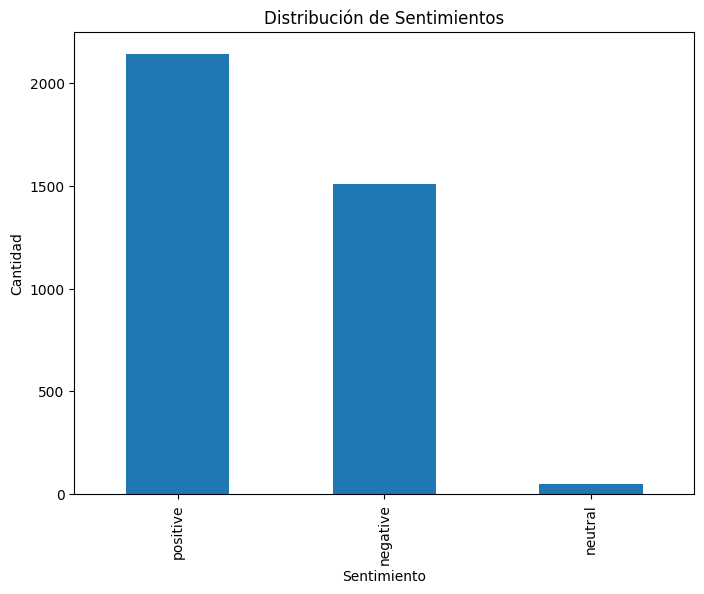

In [10]:
# Distribución de sentimientos (Gráfico de barras)
plt.figure(figsize=(8, 6))
df_reduced['Sentiment'].value_counts().plot(kind='bar')
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.show()

Del gráfico anterior se puede deducir que la mayoría de los comentarios hacia la aerolínea son POSITIVOS aunque presenta una gran cantidad de NEGATIVOS en contraposición. Los comentarios neutrales son escasos. Claramente se debe trabajar en mejorar la imagen de nuestros clientes para convertir los NEGATIVOS en POSITIVOS

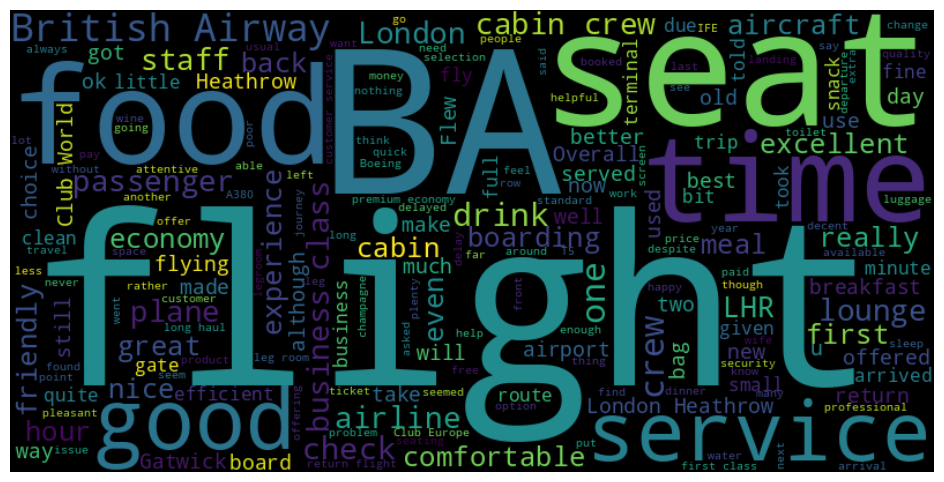

In [11]:
#Nube de palabras (para las reseñas con sentimiento positivo)
# Creamos una serie de pandas
positive_reviews = df_reduced[df_reduced['Sentiment'] == 'positive']['ReviewBody']

# Unimos la serie en un solo texto
text = ' '.join(positive_reviews)

# Creamos la Nube gráfica
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

En el gráfico podemos observar la predominancia de las siguientes palabras dentro de todas las reseñas:
* Flight
* BA
* food
* good
* service
* time

#Limpieza de datos

In [12]:
# Creamos una función para limpieza de texto con regex (Expresiones Regulares)
def limpiar_texto(texto):
    texto = re.sub(r"http\S+", "", texto)  # Eliminar URLs
    texto = re.sub(r"@\w+", "", texto)  # Eliminar menciones
    texto = re.sub(r"#\w+", "", texto)  # Eliminar hashtags
    texto = re.sub(r"[^a-zA-Z\s]", "", texto)  # Eliminar caracteres no alfabéticos
    texto = texto.lower()  # Convertir a minúsculas
    texto = texto.strip()  # Eliminar espacios extra
    return texto

In [13]:
# Hacemos copia del Dataframe y aplicamos limpieza de texto en la copia
df_reduced_re = df_reduced.copy()
df_reduced_re[text_column] = df_reduced_re[text_column].apply(limpiar_texto)

In [14]:
# Eliminar stopwords de la libreria nltk y palabras de alta y baja frecuencia, armado de noise words

# Descarga una lista de palabras vacías (stopwords) de diferentes idiomas.
nltk.download('stopwords')

# Creamos una lista vacía para guardar Stopwords
noise_words = []

# Creamos un alias para referirnos a nltk.corpus.stopwords
stopwords_corpus = nltk.corpus.stopwords

# Filtramos las palabras en Ingles
eng_stop_words = stopwords_corpus.words('english')

# Agregamos a la lista los Stopwords
noise_words.extend(eng_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Datos de Stopwords
print("Cantidad eng_stop_words: " , len(noise_words))
print("Lista de noise_words")
noise_words

In [24]:
# Tokenización
# Armamos una lista de listas de las reseñas
token_lists_original = [word_tokenize(each) for each in df_reduced_re['ReviewBody']]

# Recorremos cada lista y dentro de cada lista, recorremos cada palabra para crear la lista de tokens
tokens = [item for sublist in token_lists_original for item in sublist]

# Imprimimos número de Tokens únicos
print("Numero de token unicos antes: ", len(set(tokens)))

Numero de token unicos antes:  14117


In [26]:
#Eliminar las palabras de alta frecuencia

# Obtenemos el 10% de los Tokens
one_percentile = int(len(set(tokens)) * 0.01)

# Contamos la frecuencia de cada Token
top_1_percentile = Counter(tokens).most_common(one_percentile)

# Imprimimos los 10 Tokens más frecuentes
top_1_percentile[:10]

[('the', 29792),
 ('to', 19806),
 ('and', 18307),
 ('a', 14221),
 ('was', 13022),
 ('i', 10878),
 ('of', 8518),
 ('in', 8438),
 ('on', 7982),
 ('flight', 6611)]

In [ ]:
#Eliminar las palabras de baja frecuencia
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('provoked', 1),
 ('cheered', 1),
 ('downtime', 1),
 ('floaters', 1),
 ('roulette', 1),
 ('hog', 1),
 ('lhrathlhr', 1),
 ('lifts', 1),
 ('onboarding', 1),
 ('demonstrating', 1)]

In [ ]:
#sumar palabras de alta  y baja frecuencia a la noise_words
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

##Tratamiento de datos

In [ ]:
#Tokenización y lematización con spaCy aplicando stop words de spacy
nlp = spacy.load("en_core_web_sm")

def tokenizar_lematizar(texto):
    doc = nlp(texto)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

df['processed_text'] = df[text_column].apply(tokenizar_lematizar)

In [ ]:
df

,ReviewBody,Sentiment,processed_text
0,hours before takeoff we received a mail statin...,negative,hour takeoff receive mail state cryptic messag...
1,i recently had a delay on british airways from...,negative,recently delay british airway bru lhr staff sh...
2,boarded on time but it took ages to get to the...,positive,board time take age runway congestion flight s...
3,days before the flight we were advised by ba t...,negative,day flight advise ba cancel ask rebook flight ...
4,we traveled to lisbon for our dream vacation a...,positive,travel lisbon dream vacation cruise portugal s...
...,...,...,...
3696,this was a bmi regional operated flight on a r...,negative,bmi regional operate flight rj manchester heat...
3697,lhr to ham purser addresses all club passenger...,positive,lhr ham purser address club passenger boarding...
3698,my son who had worked for british airways urge...,positive,son work british airways urge fly british airw...
3699,london citynew york jfk via shannon on a but h...,positive,london citynew york jfk shannon nice seat prof...


In [ ]:
#Crear n-gramas y matriz de características
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Unigramas y bigramas
X = vectorizer.fit_transform(df['processed_text'])

X

<3701x159164 sparse matrix of type '<class 'numpy.int64'>'
	with 475555 stored elements in Compressed Sparse Row format>

In [ ]:
print("Shape de la matriz de características:", X.shape)

Shape de la matriz de características: (3701, 159164)


In [ ]:
# Crear un vectorizador con tokenización personalizada, excluyendo palabras de ruido
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1, 2)  # Unigrams y bigrams
)

# Ajustar y transformar el texto
X = bow_counts.fit_transform(df['processed_text'])

# Mostrar los términos generados
print("Términos:", bow_counts.get_feature_names_out())

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'might', 'must', "n't", 'need', 'sha', 'wo'] not in stop_words.
  warnings.warn(


Términos: ['aa' 'aa admiral' 'aa allow' ... 'zurich zurich' 'zusammenschluss'
 'zusammenschluss geflogen']


#Modelos de clasificación

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
X = bow_counts.fit_transform(df['processed_text'])  # Matriz de características
y = df['Sentiment']  # Etiquetas de sentimiento

In [ ]:
# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###REGRESIÓN LOGÍSTICA


In [ ]:
#Entrenamiento del modelo
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy del modelo Logistic Regression:", logreg_accuracy)

Accuracy del modelo Logistic Regression: 0.7813765182186235


###RANDOM FOREST

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy del modelo Random Forest:", rf_accuracy)

Accuracy del modelo Random Forest: 0.7408906882591093


###Comparación de resultados


In [ ]:
model_accuracies = {
    'Logistic Regression': logreg_accuracy,
    'Random Forest': rf_accuracy,

}

# Ordenar los modelos por accuracy
sorted_accuracies = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)

print("\nModelos comparados por accuracy:")
for model, accuracy in sorted_accuracies:
    print(f"{model}: {accuracy:.4f}")


Modelos comparados por accuracy:
Logistic Regression: 0.7814
Random Forest: 0.7409


* Si bien los resultados son buenos, podemos avanzar a modelos de clasificación más sofisticados para obtener resultados aún más precisos en el análisis de sentimientos.

##Aplicación de modelos más sofisticados


###TF-IDF y trigramas

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Mejorar del preprocesamiento con TF-IDF y trigramas
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')  # Unigramas, bigramas y trigramas
X_preprocesada = tfidf_vectorizer.fit_transform(df['processed_text'])  # Generar la matriz TF-IDF


###Aplicación nuevamente de los modelos Regreción Logística y Random Forest

In [ ]:
# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(X_preprocesada, y, test_size=0.2, random_state=42)

In [ ]:
#Regresión Logística
logreg_prep = LogisticRegression(max_iter=1000)
logreg_prep.fit(X_train_prep, y_train_prep)
y_pred_logreg_prep = logreg_prep.predict(X_test_prep)
logreg_accuracy_prep = accuracy_score(y_test_prep, y_pred_logreg_prep)
print("Accuracy del modelo Logistic Regression (con mejora):", logreg_accuracy_prep)

Accuracy del modelo Logistic Regression (con mejora): 0.747638326585695


In [ ]:
#Random Forest
rf_prep = RandomForestClassifier(n_estimators=100)
rf_prep.fit(X_train_prep, y_train_prep)
y_pred_rf_prep = rf_prep.predict(X_test_prep)
rf_accuracy_prep = accuracy_score(y_test_prep, y_pred_rf_prep)
print("Accuracy del modelo Random Forest (con mejora):", rf_accuracy_prep)

Accuracy del modelo Random Forest (con mejora): 0.7233468286099866


In [ ]:
# Comparar con los resultados originales
print("\nComparación:")
print(f"Logistic Regression - Original: {logreg_accuracy:.4f} | Mejorado: {logreg_accuracy_prep:.4f}")
print(f"Random Forest - Original: {rf_accuracy:.4f} | Mejorado: {rf_accuracy_prep:.4f}")


Comparación:
Logistic Regression - Original: 0.7814 | Mejorado: 0.7476
Random Forest - Original: 0.7409 | Mejorado: 0.7233


* Conclusión preliminar: aplicando TF-IDF y trigramas solo reducimos la exactitud de los modelos


###Ajuste de Hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#Definir los parámetros para GridSearchCV para Regreción Logística
logreg_params = {
    'C': [0.1, 1, 10],  # Parámetro de regularización
    'solver': ['liblinear', 'saga'],  # Solvers comunes
    'max_iter': [1000]
}

In [ ]:
logreg_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=logreg_params, cv=5, n_jobs=-1)
logreg_grid.fit(X_train_prep, y_train_prep)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [1000],
                         'solver': ['liblinear', 'saga']})

In [ ]:
# Mejor modelo para Logistic Regression
logreg_best = logreg_grid.best_estimator_
logreg_best_accuracy = accuracy_score(y_test_prep, logreg_best.predict(X_test_prep))

In [ ]:
#Definir los parámetros para Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],  # Número de árboles
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Mínimo número de muestras en una hoja
}


In [ ]:
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X_train_prep, y_train_prep)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [ ]:
# Mejor modelo para Random Forest
rf_best = rf_grid.best_estimator_
rf_best_accuracy = accuracy_score(y_test_prep, rf_best.predict(X_test_prep))

In [ ]:
# Resultados finales
print("\nMejores resultados con GridSearchCV:")
print("Mejor Accuracy para Logistic Regression (con ajuste de hiperparámetros):", logreg_best_accuracy)
print("Mejor Accuracy para Random Forest (con ajuste de hiperparámetros):", rf_best_accuracy)

# Mostrar los mejores hiperparámetros
print("\nMejores hiperparámetros para Logistic Regression:", logreg_grid.best_params_)
print("Mejores hiperparámetros para Random Forest:", rf_grid.best_params_)



Mejores resultados con GridSearchCV:
Mejor Accuracy para Logistic Regression (con ajuste de hiperparámetros): 0.7948717948717948
Mejor Accuracy para Random Forest (con ajuste de hiperparámetros): 0.7327935222672065

Mejores hiperparámetros para Logistic Regression: {'C': 10, 'max_iter': 1000, 'solver': 'saga'}
Mejores hiperparámetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


###Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Entrenar el modelo Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_prep, y_train_prep) #CON LAS MEJORAS DE PREPROCESAMIENTO

# Predicciones
y_pred_nb = nb.predict(X_test_prep)

# Métricas
nb_accuracy = accuracy_score(y_test_prep, y_pred_nb)
print("Accuracy del modelo Naive Bayes:", nb_accuracy)

# Reporte de clasificación
print("\nReporte de clasificación para Naive Bayes:")
print(classification_report(y_test_prep, y_pred_nb))

# Matriz de confusión
print("\nMatriz de confusión para Naive Bayes:")
print(confusion_matrix(y_test_prep, y_pred_nb))

Accuracy del modelo Naive Bayes: 0.6221322537112011

Reporte de clasificación para Naive Bayes:
              precision    recall  f1-score   support

    negative       0.82      0.14      0.24       306
     neutral       0.00      0.00      0.00        10
    positive       0.61      0.99      0.75       425

    accuracy                           0.62       741
   macro avg       0.48      0.37      0.33       741
weighted avg       0.69      0.62      0.53       741


Matriz de confusión para Naive Bayes:
[[ 42   0 264]
 [  3   0   7]
 [  6   0 419]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV

# Parámetros para GridSearchCV
nb_params = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}

# GridSearchCV para Multinomial Naive Bayes
nb_grid = GridSearchCV(estimator=MultinomialNB(), param_grid=nb_params, cv=5, n_jobs=-1)
nb_grid.fit(X_train_prep, y_train_prep)

# Mejor modelo y resultados
nb_best = nb_grid.best_estimator_
nb_best_accuracy = accuracy_score(y_test_prep, nb_best.predict(X_test_prep))

print("\nMejor Accuracy para Naive Bayes (con ajuste de hiperparámetros):", nb_best_accuracy)
print("\nMejores hiperparámetros para Naive Bayes:", nb_grid.best_params_)



Mejor Accuracy para Naive Bayes (con ajuste de hiperparámetros): 0.7557354925775979

Mejores hiperparámetros para Naive Bayes: {'alpha': 0.1}


##XGBoost

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Codificar las etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_prep)
y_test_encoded = label_encoder.transform(y_test_prep)

# Verificar la codificación
print("Clases originales:", label_encoder.classes_)
print("Etiquetas codificadas:", set(y_train_encoded))

Clases originales: ['negative' 'neutral' 'positive']
Etiquetas codificadas: {0, 1, 2}


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Entrenar el modelo XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_prep, y_train_encoded)

# Predicciones
y_pred_xgb = xgb.predict(X_test_prep)

# Métricas
xgb_accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print("Accuracy del modelo XGBoost:", xgb_accuracy)

# Reporte de clasificación
print("\nReporte de clasificación para XGBoost:")
print(classification_report(y_test_encoded, y_pred_xgb))

# Matriz de confusión
print("\nMatriz de confusión para XGBoost:")
print(confusion_matrix(y_test_encoded, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy del modelo XGBoost: 0.786774628879892

Reporte de clasificación para XGBoost:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       306
           1       0.00      0.00      0.00        10
           2       0.81      0.84      0.83       425

    accuracy                           0.79       741
   macro avg       0.52      0.53      0.52       741
weighted avg       0.78      0.79      0.78       741


Matriz de confusión para XGBoost:
[[224   0  82]
 [ 10   0   0]
 [ 66   0 359]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Stemming

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

In [ ]:
# Cargar el modelo de spaCy
nlp = spacy.load('en_core_web_sm')

# Inicializar el stemmer de NLTK
stemmer = PorterStemmer()

# Función para preprocesar el texto
def preprocess_text(text, stopwords_spacy, min_freq=5):
    # Convertir a minúsculas
    text = text.lower()

    # Procesar el texto con spaCy (tokenización y stopwords)
    doc = nlp(text)

    # Eliminar stopwords y seleccionar palabras alfabéticas
    tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]

    # Aplicar stemming
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(stemmed_tokens)

In [ ]:
# Filtrar las palabras de alta frecuencia (aparece en más del 5% de los documentos)
def remove_high_freq_words(texts, min_freq=5):
    all_tokens = [word_tokenize(text.lower()) for text in texts]
    # Contamos las frecuencias de las palabras
    word_counts = Counter([item for sublist in all_tokens for item in sublist])

    # Filtrar las palabras que aparecen en menos del umbral mínimo de frecuencia
    words_to_remove = {word for word, count in word_counts.items() if count > min_freq}
    return words_to_remove
high_freq_words = remove_high_freq_words(df['ReviewBody'])

In [ ]:
# Filtrar el texto aplicando stopwords y alta frecuencia
stopwords_spacy = spacy.lang.en.stop_words.STOP_WORDS
df['processed_text'] = df['ReviewBody'].apply(lambda x: preprocess_text(x, stopwords_spacy, high_freq_words))

# Verificar el resultado del preprocesamiento
print(df[['ReviewBody', 'processed_text']].head())

                                          ReviewBody  \
0  hours before takeoff we received a mail statin...   
1  i recently had a delay on british airways from...   
2  boarded on time but it took ages to get to the...   
3  days before the flight we were advised by ba t...   
4  we traveled to lisbon for our dream vacation a...   

                                      processed_text  
0  hour takeoff receiv mail state cryptic messag ...  
1  recent delay british airway bru lhr staff shor...  
2  board time took age runway congest flight smoo...  
3  day flight advis ba cancel ask rebook flight h...  
4  travel lisbon dream vacat cruis portug spain f...  


In [ ]:
# Crear una matriz de características usando CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Unigramas y bigramas
X = vectorizer.fit_transform(df['processed_text'])  # Transformar el texto preprocesado
y = df['Sentiment']  # Columna de etiquetas

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Crear una matriz de características usando CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Unigramas y bigramas
X = vectorizer.fit_transform(df['processed_text'])  # Transformar el texto preprocesado
y = df['Sentiment']  # Columna de etiquetas

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Modelo de Regresión Logística
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Accuracy Regresión Logística:", accuracy_score(y_test, y_pred_logreg))

Accuracy Regresión Logística: 0.7989203778677463


In [ ]:
# Modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Accuracy Random Forest:", accuracy_score(y_test, y_pred_rf))

Accuracy Random Forest: 0.747638326585695


##Mejora de procesos


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import re

#limpiar el texto profundamente
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'@\w+', '', text)  # Eliminar menciones
    text = re.sub(r'#\w+', '', text)  # Eliminar hashtags
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar caracteres especiales
    return text.lower()

In [ ]:
# Filtrar palabras raras
def remove_low_freq_words(texts, min_freq=3):
    all_tokens = [word for text in texts for word in word_tokenize(text)]
    word_counts = Counter(all_tokens)
    rare_words = {word for word, count in word_counts.items() if count < min_freq}
    return rare_words

In [ ]:
# Aplicar limpieza de texto profundamente
df['cleaned_text'] = df['ReviewBody'].apply(clean_text)

# Identificar palabras raras
rare_words = remove_low_freq_words(df['cleaned_text'], min_freq=3)

# Filtrar palabras raras de cada texto
df['filtered_text'] = df['cleaned_text'].apply(
    lambda text: ' '.join([word for word in word_tokenize(text) if word not in rare_words])
)

In [ ]:
# Generar representación n-gramas
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X_ngram = vectorizer.fit_transform(df['filtered_text'])

# Verificar características generadas
print(f"Número de características generadas: {X_ngram.shape[1]}")

Número de características generadas: 163517


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_ngram, df['ReviewBody'], test_size=0.3, random_state=42)


In [ ]:
# Regresión Logística
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

In [ ]:
# Predicciones y precisión para Regresión Logística
logreg_predictions = logreg_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
print(f"Accuracy de Regresión Logística: {logreg_accuracy}")

NameError: name 'logreg_model' is not defined

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
# Predicciones y precisión para Random Forest
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Accuracy de Random Forest: {rf_accuracy}")

#CONCLUSIONES
